In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip uninstall xgboost -y
!pip install -U xgboost

!pip uninstall scikit-learn -y
!pip install -U scikit-learn

Found existing installation: xgboost 0.90
Uninstalling xgboost-0.90:
  Successfully uninstalled xgboost-0.90
     |████████████████████████████████| 173.5 MB 12 kB/s 
Found existing installation: scikit-learn 1.0.1
Uninstalling scikit-learn-1.0.1:
  Successfully uninstalled scikit-learn-1.0.1
     |████████████████████████████████| 23.2 MB 40.4 MB/s 


In [3]:
!pip install dython

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
from dython import nominal
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os

In [5]:
basedir = '/content/drive/MyDrive/recidivism/'
raw_datadir = os.path.join(basedir,'data','01_raw')
interim_datadir = os.path.join(basedir,'data','02_interim')
processed_datadir = os.path.join(basedir,'data','03_processed')
modelsdir = os.path.join(basedir,'models')

In [6]:
data = pd.read_csv(os.path.join(interim_datadir,"cleaned_raw_data_final.csv"))

In [7]:
data.shape

(25835, 48)

## Fill Missing Values
Create 'Unknown' category for Gang_Affiliated, Supervision_Level_First and Prison_Offense
For the DrugTests...Positive features, create one new feature: Drug_Test_Results
Positive if any drug test had a value over 0. Negative if all drug tests were 0. Unknown if no drug test is over 0 and if at least one is missing

For Percent_Days_Employed and Supervision_Risk_Score_First we remove all rows with a missing value.

Since there is a higher correlation between Percent_Days_Employed and Jobs_Per_Year we will drop Jobs_Per_Year

Since there is a lower correlation between Avg_Days_per_DrugTest and the target variable and since there is a relatively large number of mising values, we will remove the feature 


In [8]:
data['Gang_Affiliated'] = data["Gang_Affiliated"].fillna("Unknown")
data['Supervision_Level_First'] = data["Supervision_Level_First"].fillna("Unknown")
data['Prison_Offense'] = data["Prison_Offense"].fillna("Unknown")

In [9]:
def drugTest(df):

    if df['DrugTests_THC_Positive'] > 0.0: 
        return 'Positive'
    if df['DrugTests_Cocaine_Positive'] > 0.0:
        return 'Positive'
    if df['DrugTests_Meth_Positive'] > 0.0:
        return 'Positive'
    if df['DrugTests_Other_Positive'] > 0.0:
        return 'Positive'
    if pd.isna(df['DrugTests_THC_Positive']):
        return 'Unknown'
    if pd.isna(df['DrugTests_Cocaine_Positive']):
        return 'Unknown'
    if pd.isna(df['DrugTests_Meth_Positive']):
        return 'Unknown'
    if pd.isna(df['DrugTests_Other_Positive']):
        return 'Unknown'
    else:
        return 'Negative'
    

def daysEmployed(df):
    if df['Percent_Days_Employed'] == 0:
        return "None"
    if df['Percent_Days_Employed'] == 1:
        return 'All'
    if df['Percent_Days_Employed'] < 0.5:
        return 'Less Than Half'
    else:
        return 'More Than Half'

In [10]:
data['Drug_Test_Results'] = data.apply(lambda row: drugTest(row), axis=1)
data = data[data['Percent_Days_Employed'].notnull()]
data['Percent_Days_Employed'] = data.apply(lambda row: daysEmployed(row), axis=1)

data = data[data['Supervision_Risk_Score_First'].notnull()]
data.drop(columns=['Jobs_Per_Year', 'Avg_Days_per_DrugTest'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
class GroupImputer(BaseEstimator, TransformerMixin):
    '''
    Class used for imputing missing values in a pd.DataFrame using either mean or median of a group.
    
    Parameters
    ----------    
    group_cols : list
        List of columns used for calculating the aggregated value 
    target : str
        The name of the column to impute
    metric : str
        The metric to be used for remplacement, can be one of ['mean', 'median']

    Returns
    -------
    X : array-like
        The array with imputed values in the target column
    '''
    def __init__(self, group_cols, target, metric='mean'):
        
        assert metric in ['mean', 'median'], 'Unrecognized value for metric, should be mean/median'
        assert type(group_cols) == list, 'group_cols should be a list of columns'
        assert type(target) == str, 'target should be a string'
        
        self.group_cols = group_cols
        self.target = target
        self.metric = metric
    
    def fit(self, X, y=None):
        
        assert pd.isnull(X[self.group_cols]).any(axis=None) == False, 'There are missing values in group_cols'
        
        impute_map = X.groupby(self.group_cols)[self.target].agg(self.metric) \
                                                            .reset_index(drop=False)
        
        self.impute_map_ = impute_map
        
        return self 
    
    def transform(self, X, y=None):
        
        # make sure that the imputer was fitted
        check_is_fitted(self, 'impute_map_')
        
        X = X.copy()
        
        for index, row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            X.loc[ind, self.target] = X.loc[ind, self.target].fillna(row[self.target])
        
        return X.values


In [12]:
oneHot = OneHotEncoder(drop='if_binary')

In [13]:
ct = ColumnTransformer([('OneHot',oneHot,['Gender', 'Race', 'Residence_PUMA'])],remainder='passthrough')

In [14]:
features = ['Gang_Affiliated', 'Drug_Test_Results', 'Supervision_Level_First', 'Prison_Offense', 'Percent_Days_Employed']

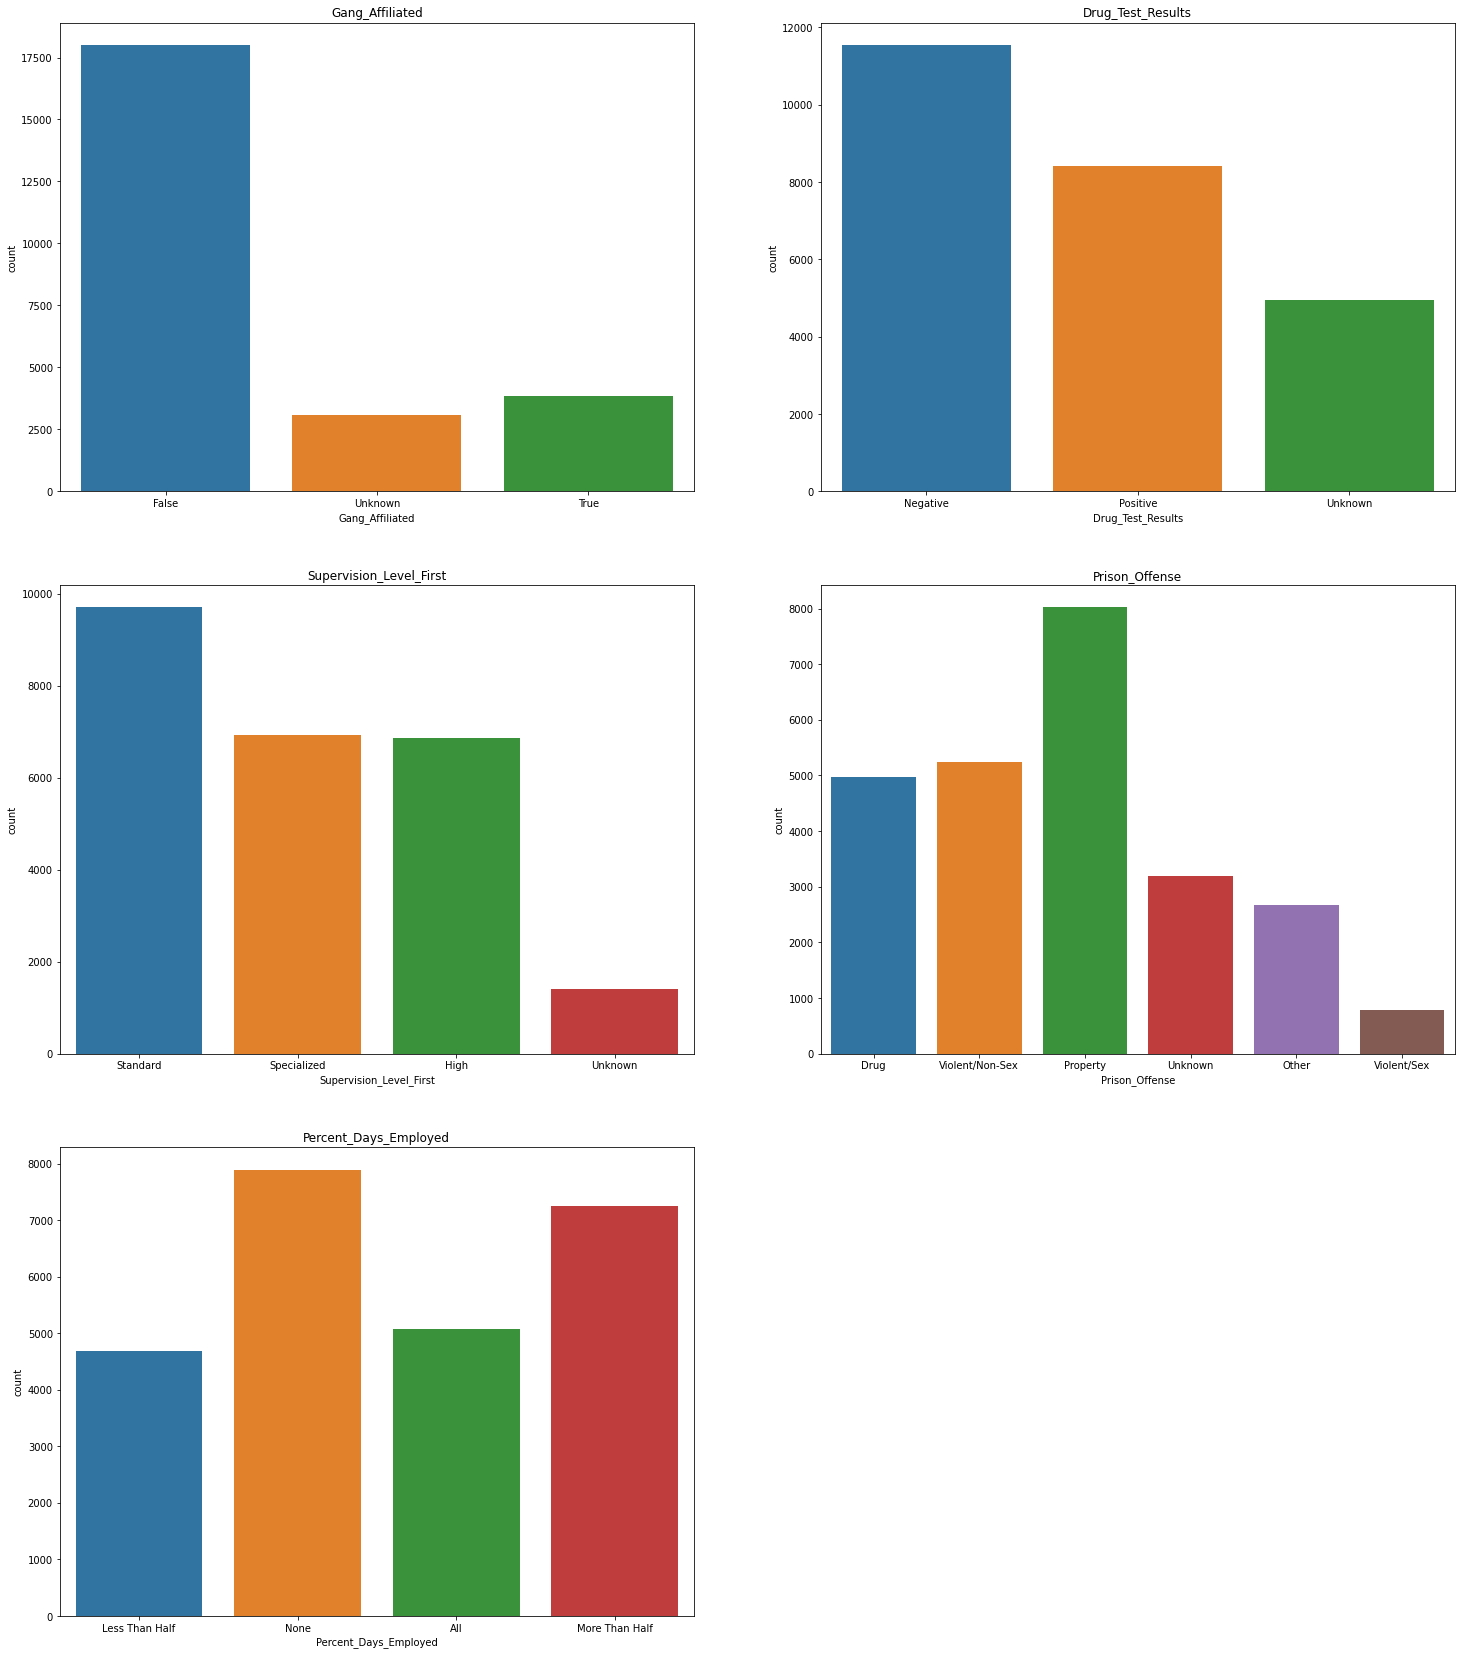

In [15]:
fig = plt.figure(figsize=(25,50))
for i in range (1,len(features)+1):
    ax = plt.subplot(math.ceil(len(features)),2,i)
    sns.countplot(data = data, x=features[i-1], ax=ax)
    plt.title(features[i-1])
plt.show()

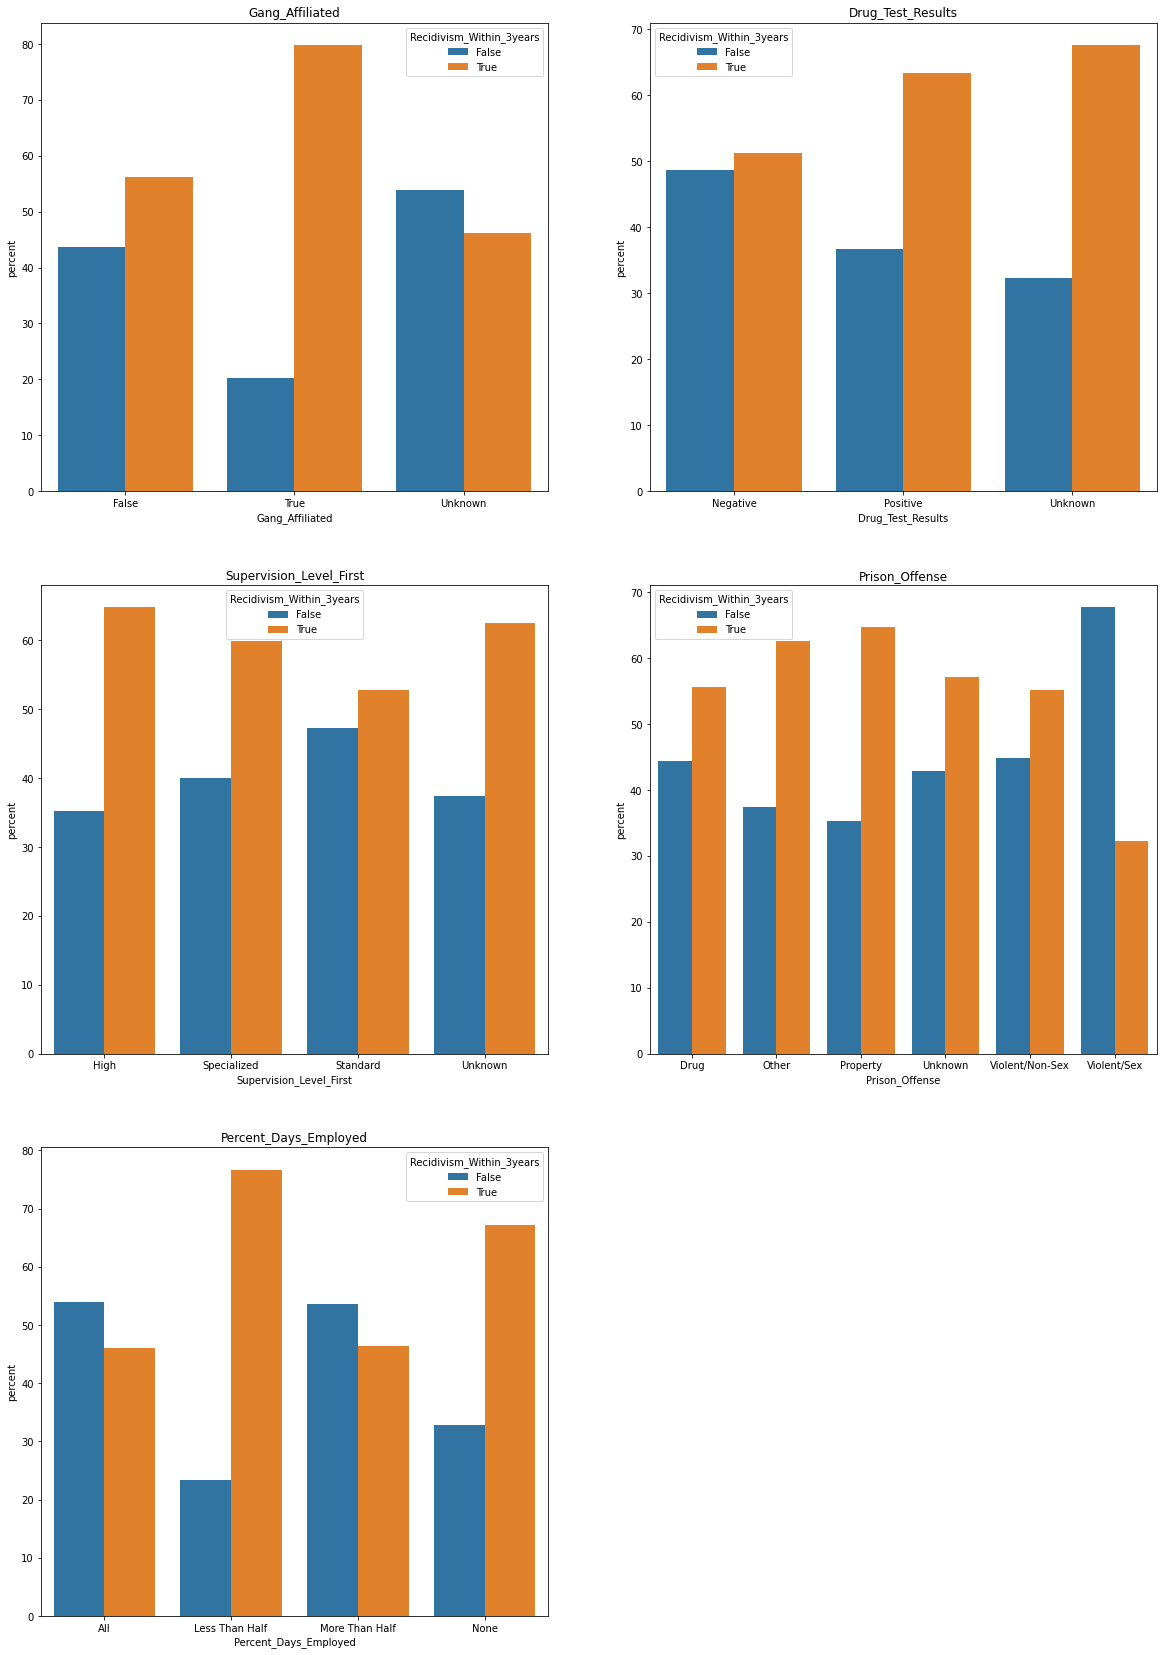

In [16]:
features = [['Gang_Affiliated', 'Drug_Test_Results', 'Supervision_Level_First', 'Prison_Offense', 'Percent_Days_Employed']]
for cats in features:
    x = 10 * math.ceil(len(cats))
    fig = plt.figure(figsize=(20,x))
    for i in range (1,len(cats)+1):
        ax = plt.subplot(math.ceil(len(cats)),2,i)
        y = 'Recidivism_Within_3years'
        (data.groupby(cats[i-1])['Recidivism_Within_3years'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.barplot, 'data'),x=cats[i-1], y='percent', hue=y, ax=ax))
        plt.title(cats[i-1])
    plt.show()

In [17]:
print(data.shape)
data.drop(columns=['DrugTests_THC_Positive',
                   'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive',
                   'DrugTests_Other_Positive'], inplace=True)
print(data.shape)
dir = os.path.join(interim_datadir,"binned_data.csv")
data.to_csv(dir, header=True, index=False)

(24900, 47)
(24900, 43)


# Review Drug_Test_Results


## Correlation with Target Variable

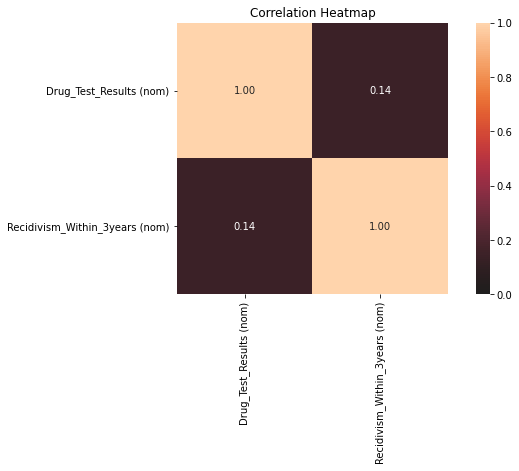

In [18]:

drug_corr = data[['Drug_Test_Results', 'Recidivism_Within_3years']]
nominal.associations(drug_corr, nominal_columns = ['Drug_Test_Results', 'Recidivism_Within_3years'],figsize=(10,5), mark_columns=True, title="Correlation Heatmap")

plt.show()

In [19]:
cross = pd.crosstab(data['Recidivism_Within_3years'], data['Drug_Test_Results'])
chi2_score, p_score, dof_value, expected_array = chi2_contingency(cross)
pd.DataFrame([chi2_score, p_score, dof_value, expected_array], index=['chi2_score', 'p_score', 'dof_value', 'expected_array'])

,0
chi2_score,497.266
p_score,1.0475e-108
dof_value,2
expected_array,"[[4776.519919678715, 3477.518313253012, 2046.9..."


## Split dataset into feature and label datasets. Label Encode label dataset.

In [20]:
labels = data['Recidivism_Within_3years']
features = data.drop(columns=['Recidivism_Within_3years'], inplace=False)

In [21]:
print('Shape of full dataset:',data.shape)
print('Shape of features:',features.shape)
print('Shape of labels:',labels.shape)

Shape of full dataset: (24900, 43)
Shape of features: (24900, 42)
Shape of labels: (24900,)


In [22]:
le = LabelEncoder()
labels = pd.DataFrame(le.fit_transform(labels))



In [23]:
labels.shape

(24900, 1)

## Save labels and features datasets

In [24]:
labelpath = os.path.join(processed_datadir,"labels.csv")
featurespath = os.path.join(processed_datadir,"features.csv")

labels.to_csv(labelpath, header=True, index=False)
features.to_csv(featurespath, header=True, index=False)



## Train/Test Split Datasets

In [25]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, stratify=labels)


In [26]:
y_train.shape

(17430, 1)

In [27]:
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [28]:
print('X_train shape:',X_train.shape)
print('X_test shape:',X_test.shape)
print('y_train shape:',y_train.shape)
print('y_test shape:',y_test.shape)

X_train shape: (17430, 42)
X_test shape: (7470, 42)
y_train shape: (17430, 1)
y_test shape: (7470, 1)


In [29]:
print('X_train_xgb shape:',X_train_xgb.shape)
print('X_val_xgb shape:',X_val_xgb.shape)
print('y_train_xgb shape:',y_train_xgb.shape)
print('y_val_xgb shape:',y_val_xgb.shape)

X_train_xgb shape: (13944, 42)
X_val_xgb shape: (3486, 42)
y_train_xgb shape: (13944, 1)
y_val_xgb shape: (3486, 1)


## Save Train and Test Datasets

In [30]:
xtrain_path = os.path.join(processed_datadir, "Xtrain.csv")
xtest_path = os.path.join(processed_datadir, "Xtest.csv")
ytrain_path = os.path.join(processed_datadir, "ytrain.csv")
ytest_path = os.path.join(processed_datadir, "ytest.csv")

xtrain_xgb_path = os.path.join(processed_datadir, "Xtrain_xgb.csv")
xval_xgb_path = os.path.join(processed_datadir, "Xval_xgb.csv")
ytrain_xgb_path = os.path.join(processed_datadir, "ytrain_xgb.csv")
yval_xgb_path = os.path.join(processed_datadir, "yval_xgb.csv")

X_train.to_csv(xtrain_path, header=True, index=False)
X_test.to_csv(xtest_path, header=True, index=False)
y_train.to_csv(ytrain_path, header=True, index=False)
y_test.to_csv(ytest_path, header=True, index=False)

X_train_xgb.to_csv(xtrain_xgb_path, header=True, index=False)
X_val_xgb.to_csv(xval_xgb_path, header=True, index=False)
y_train_xgb.to_csv(ytrain_xgb_path, header=True, index=False)
y_val_xgb.to_csv(yval_xgb_path, header=True, index=False)

In [31]:
X_train.isnull().sum()

Gender                                               0
Race                                                 0
Age_at_Release                                       0
Residence_PUMA                                       0
Gang_Affiliated                                      0
Supervision_Risk_Score_First                         0
Supervision_Level_First                              0
Education_Level                                      0
Dependents                                           0
Prison_Offense                                       0
Prison_Years                                         0
Prior_Arrest_Episodes_Felony                         0
Prior_Arrest_Episodes_Misd                           0
Prior_Arrest_Episodes_Violent                        0
Prior_Arrest_Episodes_Property                       0
Prior_Arrest_Episodes_Drug                           0
Prior_Arrest_Episodes_PPViolationCharges             0
Prior_Arrest_Episodes_DVCharges                      0
Prior_Arre

In [32]:
colnames = features.columns

In [34]:
len(colnames)

42

In [35]:
len(features)

24900